In this notebook we will try to cluster student performance on several test. Dataset used in this notebook can be accessed from [link](https://www.kaggle.com/datasets/phuc16102001/vietnam-highschool-exam-2017-to-2021?select=2017-2021.csv).

This quick clustering run-through will use Gaussian Mixture Model and BIC and AIC score to evaluate the optimal cluster based on model persepective.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings(action='ignore')

## Data Loading

In [2]:
df = pd.read_csv('2017-2021.csv')
df = df[df['Year']==2021].sample(3000)
df.shape

(3000, 12)

In [3]:
df.head()

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3781312,28037555,8.6,7.75,NaN,NaN,9.2,2021,NaN,7.00,8.00,9.75,28
3701613,25012548,9.0,5.75,8.25,5.75,9.4,2021,5.75,NaN,NaN,NaN,25
3800214,30016022,5.6,7.25,NaN,NaN,6.0,2021,NaN,7.75,7.75,8.50,30
3844457,35001161,3.8,5.75,NaN,NaN,3.0,2021,NaN,3.75,5.00,5.75,35
3351927,1078114,5.2,5.50,NaN,NaN,NaN,2021,NaN,3.50,6.50,NaN,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 3781312 to 4133710
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SBD        3000 non-null   int64  
 1   Toan       2957 non-null   float64
 2   Van        2954 non-null   float64
 3   Ly         1111 non-null   float64
 4   Sinh       1105 non-null   float64
 5   Ngoai ngu  2638 non-null   float64
 6   Year       3000 non-null   int64  
 7   Hoa        1122 non-null   float64
 8   Lich su    1859 non-null   float64
 9   Dia ly     1835 non-null   float64
 10  GDCD       1562 non-null   float64
 11  MaTinh     3000 non-null   int64  
dtypes: float64(9), int64(3)
memory usage: 304.7 KB


In [5]:
df.describe()

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
count,3.000000e+03,2957.000000,2954.000000,1111.000000,1105.000000,2638.000000,3000.0,1122.000000,1859.000000,1835.000000,1562.000000,3000.000000
mean,2.720460e+07,6.708488,6.498267,6.608686,5.571267,5.988628,2021.0,6.649287,5.027031,6.995232,8.417574,27.188333
std,1.966401e+07,1.639424,1.356988,1.381445,1.456907,2.210999,0.0,1.590244,1.760858,1.139415,1.157988,19.674668
min,1.000360e+06,1.200000,0.500000,2.000000,1.500000,1.400000,2021.0,1.500000,1.000000,1.750000,0.000000,1.000000
25%,6.002278e+06,5.600000,5.750000,5.750000,4.500000,4.000000,2021.0,5.500000,3.750000,6.250000,7.750000,6.000000
50%,2.700184e+07,7.000000,6.750000,6.750000,5.500000,5.800000,2021.0,7.000000,4.750000,7.000000,8.750000,27.000000
75%,4.400877e+07,8.000000,7.500000,7.750000,6.500000,8.000000,2021.0,8.000000,6.250000,7.750000,9.250000,44.000000
max,6.400676e+07,9.800000,9.500000,9.500000,9.750000,10.000000,2021.0,9.500000,9.750000,10.000000,10.000000,64.000000


In [6]:
df.head(2)

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3781312,28037555,8.6,7.75,NaN,NaN,9.2,2021,NaN,7.0,8.0,9.75,28
3701613,25012548,9.0,5.75,8.25,5.75,9.4,2021,5.75,NaN,NaN,NaN,25


In [7]:
# select numerical only
num = ['Toan','Van','Ly','Sinh','Ngoai ngu',
       'Hoa','Lich su','Dia ly','GDCD']

dfc = df[num]

In [8]:
dfc.isnull().sum() / dfc.shape[0] * 100

Toan          1.433333
Van           1.533333
Ly           62.966667
Sinh         63.166667
Ngoai ngu    12.066667
Hoa          62.600000
Lich su      38.033333
Dia ly       38.833333
GDCD         47.933333
dtype: float64

In [9]:
# drop columns with high proportion of MV (>40%)
dfc.drop(['Ly', 'Sinh', 'Hoa', 'GDCD'], axis=1, inplace=True)

In [10]:
# drop rows with MV
dfc.dropna(axis=0, inplace=True)

In [11]:
dfc.isnull().sum() / dfc.shape[0] * 100

Toan         0.0
Van          0.0
Ngoai ngu    0.0
Lich su      0.0
Dia ly       0.0
dtype: float64

In [12]:
X = dfc.copy()

In [13]:
clus_sample = dfc.index.tolist()

## EDA ANALYSIS

In [14]:
# cek korelasi antara setiap mapel
# dsb
dfc.shape

(1558, 5)

In [15]:
# check skewness
for i in dfc.columns:
    print(i, ': ', dfc[i].skew())

Toan :  -0.4135637010664546
Van :  -0.5117752822654756
Ngoai ngu :  0.4741194784380563
Lich su :  0.2801339225460753
Dia ly :  -0.28641941402149174


In [16]:
# check outlier
wins_gauss = Winsorizer(capping_method='gaussian', fold=3, tail='both')
dfc = wins_gauss.fit_transform(dfc)

In [17]:
# scaling
scaler = MinMaxScaler()
dfc = pd.DataFrame(scaler.fit_transform(dfc))
dfc.head()

,0,1,2,3,4
0,0.873648,0.750983,0.904762,0.685714,0.673068
1,0.494592,0.679836,0.523810,0.771429,0.632201
2,0.267158,0.466393,0.166667,0.314286,0.182669
3,0.848377,0.679836,0.714286,0.942857,0.836534
4,0.241887,0.252950,0.238095,0.200000,0.468735


In [18]:
# check VIF
# -----

In [19]:
# PCA
pca = PCA()
pca.fit(dfc)

np.cumsum(pca.explained_variance_ratio_)
# check elbow with visualization

array([0.58097645, 0.75693923, 0.86494288, 0.93836808, 1.        ])

In [20]:
pca = PCA(n_components=.90)
dfc = pd.DataFrame(pca.fit_transform(dfc))
dfc


,0,1,2,3
0,-0.615862,-0.073141,0.089981,-0.042227
1,-0.201873,0.218493,0.052826,0.165346
2,0.527911,-0.074761,-0.044453,0.130629
3,-0.607225,0.288479,0.142479,-0.068882
4,0.532622,-0.036692,0.162242,0.056075
...,...,...,...,...
1553,-0.057171,0.112880,0.134461,-0.063910
1554,-0.457034,-0.060387,0.048541,0.046281
1555,-0.079020,0.120723,-0.027928,-0.073244
1556,0.394687,-0.149773,0.097577,0.203952


<AxesSubplot:xlabel='0', ylabel='1'>

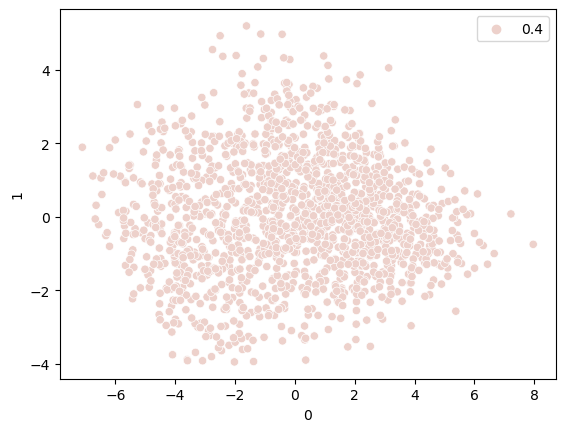

In [21]:
# for visualization, only 2 PC's saved
pca_viz = PCA(n_components=2)
X_viz = pd.DataFrame(pca_viz.fit_transform(X))
sns.scatterplot(X_viz[0], X_viz[1],hue=0.4)

## Preprocess

In [22]:
pipe = Pipeline([
    ('wins', Winsorizer(capping_method='gaussian', fold=3, tail='both')),
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=.90))
])

In [23]:
X.head(3)

,Toan,Van,Ngoai ngu,Lich su,Dia ly
3781312,8.6,7.75,9.2,7.00,8.00
3800214,5.6,7.25,6.0,7.75,7.75
3844457,3.8,5.75,3.0,3.75,5.00


In [24]:
X_tr = pipe.fit_transform(X)
X_tr

array([[-0.61586163, -0.07314057,  0.08998063, -0.04222737],
       [-0.20187255,  0.21849259,  0.05282589,  0.1653463 ],
       [ 0.52791103, -0.07476111, -0.04445325,  0.13062926],
       ...,
       [-0.07902007,  0.12072335, -0.02792839, -0.0732442 ],
       [ 0.3946867 , -0.14977321,  0.09757667,  0.20395164],
       [ 0.06478612, -0.04723249, -0.0514702 ,  0.20508526]])

## Modeling

In [25]:
# Get Best Cluster and Best Hyperparameter
# You can think of the code below as GridSearchCV process on Supervised Learning
min_aic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        aic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_tr).aic(X_tr)
        if aic < min_aic:
            min_aic = aic
            best_k = k
            best_covariance_type = covariance_type

print('Best - n_components    : ', best_k)
print('Best - covariance_type : ', best_covariance_type)

Best - n_components    :  10
Best - covariance_type :  full


Based on model's perspective, the optimal cluster was 8 with `full` covariance type.

However from user perspective, 8 cluster is too much. They expect maximum number of cluster is 5. so let's rerun our hyperparameter test with maximum 5 clusters.

In [26]:
models = [GaussianMixture(n_components=k, covariance_type='full') for k in range(2,6)]
aic = [model.fit(X_tr).aic(X_tr) for model in models]

for k, skor in zip(range(2,6), aic):
    print(k, ': ', skor)

2 :  -3490.9321308697636
3 :  -3603.7148490607037
4 :  -3711.998947408774
5 :  -3731.6692480518054


In [27]:
k_5 = GaussianMixture(n_components=5)
labelz = k_5.fit_predict(X_tr)
labelz

array([1, 4, 3, ..., 4, 3, 2])

<AxesSubplot:xlabel='0', ylabel='1'>

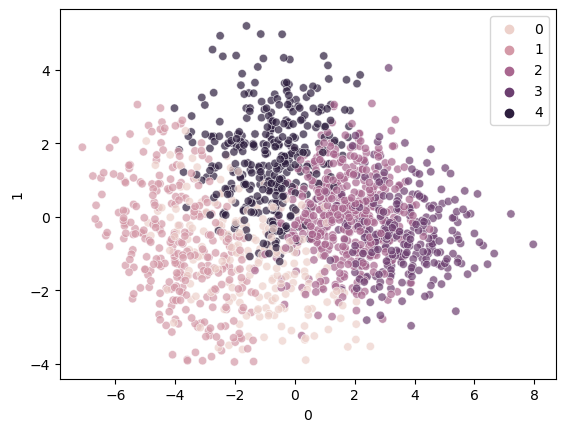

In [28]:
# visualize segmentation of 5 cluster in 2 PC's
sns.scatterplot(X_viz[0], X_viz[1], hue=labelz, alpha=.7)

<AxesSubplot:xlabel='0', ylabel='1'>

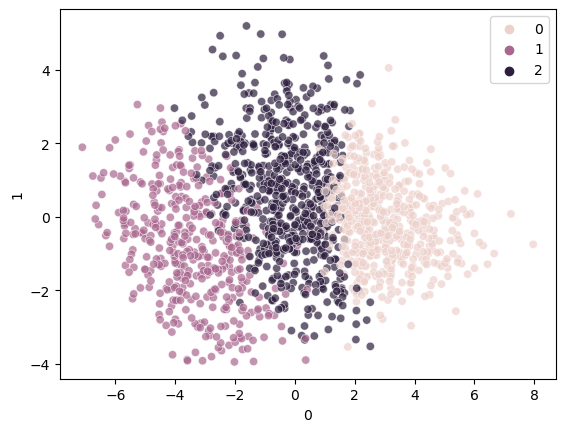

In [29]:
# you can try to visualize other n_cluster to see which one gives better separation
k_3 = GaussianMixture(n_components=3)
label3 = k_3.fit_predict(X_tr)

# visualize segmentation of 5 cluster in 2 PC's
sns.scatterplot(X_viz[0], X_viz[1], hue=label3, alpha=.7)

## EDA CLuster

In [30]:
df_eda = df.loc[clus_sample].copy()
df_eda

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
3781312,28037555,8.6,7.75,NaN,NaN,9.2,2021,NaN,7.00,8.00,9.75,28
3800214,30016022,5.6,7.25,NaN,NaN,6.0,2021,NaN,7.75,7.75,8.50,30
3844457,35001161,3.8,5.75,NaN,NaN,3.0,2021,NaN,3.75,5.00,5.75,35
4111054,55004135,8.4,7.25,NaN,NaN,7.6,2021,NaN,9.25,9.00,10.00,55
3530646,10003451,3.6,4.25,NaN,NaN,3.6,2021,NaN,2.75,6.75,6.50,10
...,...,...,...,...,...,...,...,...,...,...,...,...
3841761,34015199,6.4,5.75,NaN,NaN,5.6,2021,NaN,5.50,8.25,6.75,34
3910859,40015091,7.4,7.75,NaN,NaN,8.4,2021,NaN,6.25,8.00,9.00,40
4104515,54011346,6.8,6.75,NaN,NaN,5.0,2021,NaN,5.50,8.00,8.50,54
3361107,1087583,3.6,5.50,NaN,NaN,4.8,2021,NaN,4.00,5.25,7.25,1


In [31]:
df_eda['cluster'] = label3
df_eda

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh,cluster
3781312,28037555,8.6,7.75,NaN,NaN,9.2,2021,NaN,7.00,8.00,9.75,28,1
3800214,30016022,5.6,7.25,NaN,NaN,6.0,2021,NaN,7.75,7.75,8.50,30,2
3844457,35001161,3.8,5.75,NaN,NaN,3.0,2021,NaN,3.75,5.00,5.75,35,0
4111054,55004135,8.4,7.25,NaN,NaN,7.6,2021,NaN,9.25,9.00,10.00,55,1
3530646,10003451,3.6,4.25,NaN,NaN,3.6,2021,NaN,2.75,6.75,6.50,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3841761,34015199,6.4,5.75,NaN,NaN,5.6,2021,NaN,5.50,8.25,6.75,34,2
3910859,40015091,7.4,7.75,NaN,NaN,8.4,2021,NaN,6.25,8.00,9.00,40,1
4104515,54011346,6.8,6.75,NaN,NaN,5.0,2021,NaN,5.50,8.00,8.50,54,2
3361107,1087583,3.6,5.50,NaN,NaN,4.8,2021,NaN,4.00,5.25,7.25,1,0


In [32]:
# for example purpose, using .describe
df_eda.groupby('cluster').mean()
# for graded challenge, utilizing visualization in EDA:_clustering_result is a must

,SBD,Toan,Van,Ly,Sinh,Ngoai ngu,Year,Hoa,Lich su,Dia ly,GDCD,MaTinh
cluster,,,,,,,,,,,,
0,2.886097e+07,4.812190,5.628400,NaN,NaN,3.455619,2021.0,NaN,3.746190,6.350476,7.734165,28.847619
1,2.226321e+07,7.428922,7.585172,NaN,NaN,8.425000,2021.0,NaN,6.053309,7.620711,8.888206,22.245098
2,2.896906e+07,6.547200,6.772544,NaN,NaN,5.021120,2021.0,NaN,5.559600,7.379200,8.690916,28.955200


- make personalization for each cluster based on its character
- utilize cluster information to make strategy

**personalization**:
- cluster 0: slow learner
- cluster 1: high-achiever
- cluster 2: moderate

**strategy**:
- make peer-study-group consist of 5 students with proportion 2:2:1 from cluster 0:2:1